In [1]:
from Models.DecisionTree import MyTreeReg, TreeNode, mse, msep
from google.oauth2 import service_account
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from datetime import date
import seaborn as sns
import itertools
from time import time
import holidays
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
pd.set_option ('display.max_columns', 599)
pd.set_option ('display.max_rows', 599)

project_id = 'kolesa-android-app'
credentials = 'kolesa-android-app-715adc9bdf26.json'
credentials = service_account.Credentials.from_service_account_file(credentials)
q = "SELECT * FROM `kolesa-android-app.academy.time_series_dataset` ORDER BY 1"
data = pd.read_gbq(q, project_id=project_id, credentials=credentials, dialect='standard', progress_bar_type = 'tqdm')
#data = pd.read_csv('Data/data.csv')
data.head()

Downloading: 100%|█████████████████████████████████████████████████████████████|


,event_date,y
0,2020-01-01,5721
1,2020-01-02,8274
2,2020-01-03,9344
3,2020-01-04,9864
4,2020-01-05,10435


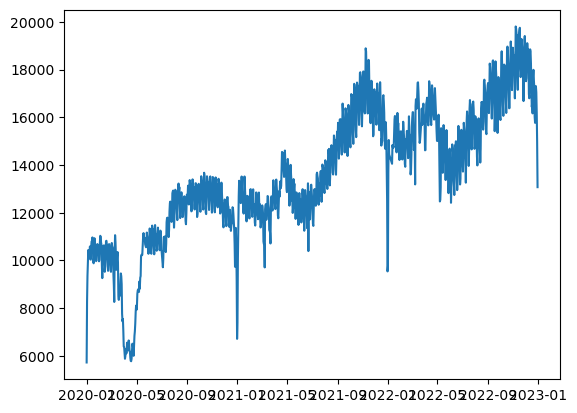

In [3]:
data = data.drop_duplicates()
data = data.drop(data[data['y'] > 1000000].index)
data = data.drop(data[data['y'] < 5000].index)
data.columns = ['ds', 'y']
data['ds'] = pd.to_datetime(data['ds'])
data = data.drop(data.query('ds == "2022-01-10"').index)
data = data.drop(data.query('ds == "2022-12-31"').index)
plt.plot(data['ds'], data['y'])

In [4]:
def ramadan(ds):
    date = pd.to_datetime(ds)
    return (date >= pd.to_datetime('2020-04-24') and date<= pd.to_datetime('2020-05-24')
           or date >= pd.to_datetime('2021-04-13') and date<= pd.to_datetime('2021-05-13')
           or date >= pd.to_datetime('2022-04-03') and date<= pd.to_datetime('2022-05-03')
           or date >= pd.to_datetime('2023-03-23') and date <= pd.to_datetime('2023-04-24'))
def corona(ds):
    date = pd.to_datetime(ds)
    return (date >= pd.to_datetime('2020-03-18') and date<= pd.to_datetime('2020-05-11'))
data['is_ramadan'] = data['ds'].apply(ramadan)
data['is_corona'] = data['ds'].apply(corona)
data['ramadan'] = data['is_ramadan'].apply(int)
data['corona'] = data['is_corona'].apply(int)
data.ds = pd.to_datetime(data['ds'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1086 entries, 0 to 1094
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ds          1086 non-null   datetime64[ns]
 1   y           1086 non-null   Int64         
 2   is_ramadan  1086 non-null   bool          
 3   is_corona   1086 non-null   bool          
 4   ramadan     1086 non-null   int64         
 5   corona      1086 non-null   int64         
dtypes: Int64(1), bool(2), datetime64[ns](1), int64(2)
memory usage: 45.6 KB


In [5]:
data.drop('is_ramadan', axis=1, inplace=True)
data.drop('is_corona', axis=1, inplace=True)

In [6]:
holidays_kz = holidays.KZ(years = (2020, 2021, 2022, 2023))
df_holidays = pd.DataFrame.from_dict(holidays_kz, orient = 'index').rename(columns = {0:'holiday'})
df_holidays['ds'] = df_holidays.index
df_holidays.reset_index(drop=True, inplace=True)
df_holidays

,holiday,ds
0,New Year,2020-01-01
1,New Year,2020-01-02
2,Orthodox Christmas,2020-01-07
3,International Women's Day,2020-03-08
4,Nauryz holiday,2020-03-22
5,Nauryz holiday,2020-03-21
6,Nauryz holiday,2020-03-23
7,Kazakhstan People Solidarity Holiday,2020-05-01
8,Defender of the Fatherland Day,2020-05-07
9,Victory Day,2020-05-09


In [7]:
data['is_holiday'] = data['ds'].isin(df_holidays['ds'])
data['is_holiday'] = data['is_holiday'].apply(int)
reference_date = pd.Timestamp('2019-12-30')
data['years'] = (data['ds']).dt.year
data['months'] = (data['ds'] ).dt.month
data['days'] = (data['ds']).dt.day
data['dayoftheweek'] = (data['ds']).dt.dayofweek
data['days_since_years'] = np.log((data['ds']).dt.year - 2018)
data['days_since_months'] = np.log((data['ds'] ).dt.month+1)
data['days_since_days'] = np.log((data['ds']).dt.day+1)
data['days_passed'] = (data['ds'] - reference_date).dt.days
data

,ds,y,ramadan,corona,is_holiday,years,months,days,dayoftheweek,days_since_years,days_since_months,days_since_days,days_passed
0,2020-01-01,5721,0,0,1,2020,1,1,2,0.693147,0.693147,0.693147,2
1,2020-01-02,8274,0,0,1,2020,1,2,3,0.693147,0.693147,1.098612,3
2,2020-01-03,9344,0,0,0,2020,1,3,4,0.693147,0.693147,1.386294,4
3,2020-01-04,9864,0,0,0,2020,1,4,5,0.693147,0.693147,1.609438,5
4,2020-01-05,10435,0,0,0,2020,1,5,6,0.693147,0.693147,1.791759,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090,2022-12-26,17304,0,0,0,2022,12,26,0,1.386294,2.564949,3.295837,1092
1091,2022-12-27,17042,0,0,0,2022,12,27,1,1.386294,2.564949,3.332205,1093
1092,2022-12-28,16195,0,0,0,2022,12,28,2,1.386294,2.564949,3.367296,1094
1093,2022-12-29,14966,0,0,0,2022,12,29,3,1.386294,2.564949,3.401197,1095


In [8]:
data.y = data.y.astype('int')
train = data[:731]
test = data[731:]
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 731 entries, 0 to 731
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ds                 731 non-null    datetime64[ns]
 1   y                  731 non-null    int64         
 2   ramadan            731 non-null    int64         
 3   corona             731 non-null    int64         
 4   is_holiday         731 non-null    int64         
 5   years              731 non-null    int32         
 6   months             731 non-null    int32         
 7   days               731 non-null    int32         
 8   dayoftheweek       731 non-null    int32         
 9   days_since_years   731 non-null    float64       
 10  days_since_months  731 non-null    float64       
 11  days_since_days    731 non-null    float64       
 12  days_passed        731 non-null    int64         
dtypes: datetime64[ns](1), float64(3), int32(4), int64(5)
memory usage: 68.

0.15818714038598358

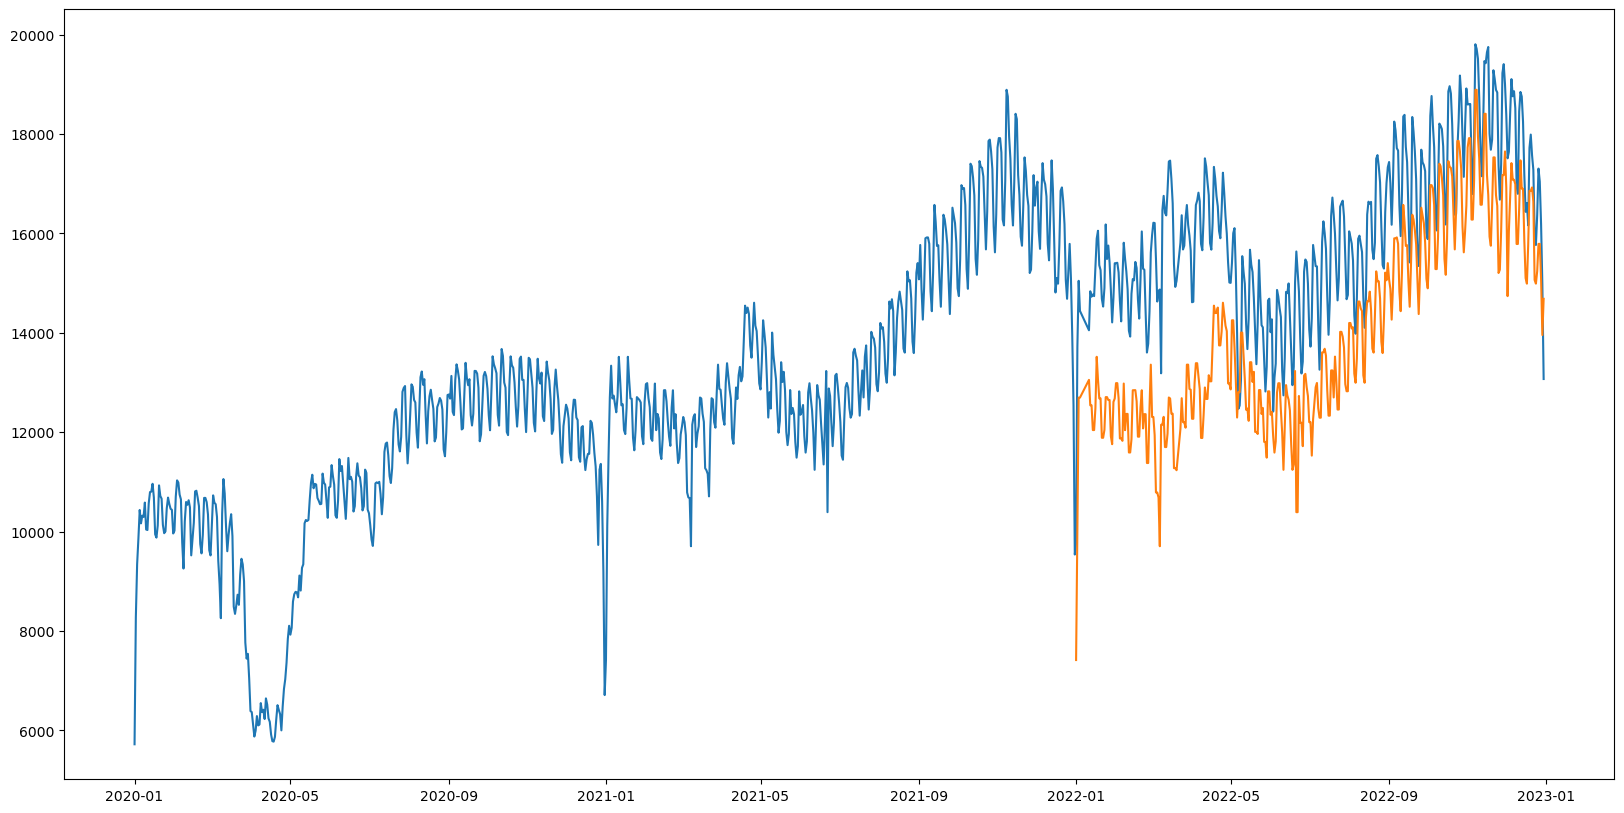

In [10]:
model = MyTreeReg(max_depth=60, min_samples_split=1, max_leafs=1000)
model.fit(train[['years', 'months','days', 'dayoftheweek']], train['y'])
y_pred = model.predict(test[['years', 'months','days','dayoftheweek']])
plt.figure(figsize=(20, 10))
plt.plot(data['ds'], data['y'], label='Actual')
plt.plot(data.query('ds >= "2022-01-01"')['ds'], y_pred, label='Forecast')
mean_absolute_percentage_error(y_pred, test['y'])